# Network Epidemiology

<div style="display: flex; align-items: center;">
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/docs/m09-netepi/lab09.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" style="vertical-align: -8px; margin-right: 10px;" />
        Open this notebook in Google Colab
    </a>
</div>


<div style="display: flex; align-items: center;">
    <a href="https://raw.githubusercontent.com/yy/netsci-course/master/docs/m09-netepi/lab09.ipynb" download>
        <img src="http://yyahn.com/netsci-course/images/download_icon.png" style="vertical-align: -8px; margin-right: 10px;" />
        Download this notebook (File -> Save As)
    </a>
</div>

You may remember the March of 2020. 👀

<img src="https://yyiki.s3.us-east-2.amazonaws.com/public/imgs/month_of_2020-time_spent_looking_at_exponential_graphs.jpg" width="400">

It was crazy how everything in our lives was suddenly governed by this new pathogen. It was a time when we all became armchair epidemiologists. We were all trying to understand the exponential growth of the virus and how it was spreading across the world. We were all trying to understand the basic reproduction number $R_0$ and how it was affecting the spread of the virus.

Let's bring back some of that excitement(?) and learn how network perspectives can help us understand the spread of infectious diseases!

## Friendship paradox, again. 

The first and probably the most important insight that network science can provide to epidemiology is the biased sampling happening in an epidemic. This is the exactly same bias that we saw in the friendship paradox.

Imagine a contact network through which a disease is spreading. Imagine that someone in the network just caught the virus and will spread to their neighbors. In this case, who will be the most likely to be the next victim of the virus? If every contact is equally likely to be infected, then the probability is proportional to the likelihood of them _appearing_ in the contact list of the infected. And as we have learned multiple times, this is roughly proportional to the degree of the node due to the friendship paradox! 

Let's quickly simulate this. 

In [13]:
import networkx as nx
import random

G = nx.barabasi_albert_graph(1000, 4)

# sample a random node as the initial infected node (index case)
index_node = random.choice(list(G.nodes()))
secondary_infections = [
    node for node in G.neighbors(index_node) if random.random() < 0.5
]
print("index: ", index_node)
print("secondary: ", secondary_infections)
print("degree of index: ", G.degree(index_node))
print("degree of secondary: ", [G.degree(node) for node in secondary_infections])

index:  254
secondary:  [66, 38, 996]
degree of index:  6
degree of secondary:  [14, 42, 4]


Let's repeat many times to get the degree distribution (use CCDF). 

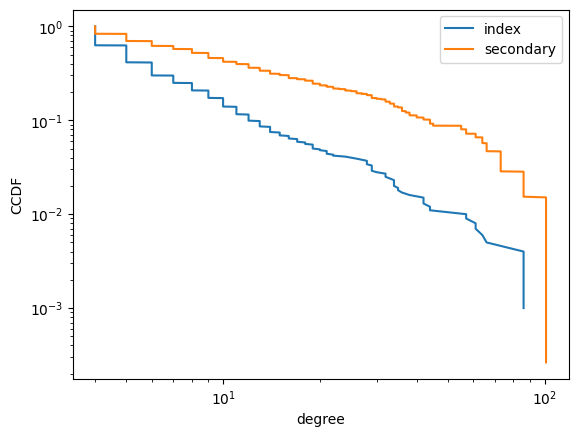

In [33]:
# repeat the simple simulation to obtain the degree distribution of the index and secondary nodes.
# The degree distribution of the secondary nodes is expected to be different from the index node.
import matplotlib.pyplot as plt
import numpy as np

N = 1000
infection_probability = 0.5
index_degrees = []
secondary_degrees = []

# YOUR SOLUTION HERE

As we expected, the secondary infection is more likely to happen to the nodes with higher degree. If you are well-connected, then you're more likely to get infected! 

## Generating functions, contact tracing, and friendship paradox

One fascinating implication of this happens in the context of contact tracing, which I published during the pandemic: [Kojaku et al., The effectiveness of backward contact tracing in networks, Nature Physics, 2021](https://www.nature.com/articles/s41567-021-01187-2). 

Let's first write down the generating function for the degree distribution of the underlying network. With the degree distribution represented by $\{ p_k \}$, the probability generating function is written as:

$$ G_0(x) = \sum_k p_k x^k. $$

Now, imagine a node with degree $k$ that has just infected by another node. If we think about the remaining degree that the infected node can further spread the disease, that's $k-1$ (because one of the edges is already used to infect the current node). Then the generating function for the remaining degree (that the node can propagate the disease) distribution is:

$$ G_1(x) = \frac{1}{\langle k \rangle} \sum_k k p_k x^{k-1} = \frac{G_0'(x)}{G_0'(1)}. $$

This means that, if we randomly sample those who are infected, then we expect to see this distribution. 

Interestingly, when we do contact tracing, another factor comes into play. First, think about two directions of contact tracing. When we found an infected person, we can try to identify who infected this person (backward contact tracing) or whom this person infected (forward contact tracing).

Forward tracing will produce the same distribution because we are simply following the edge to sample a new node, which is, according to the friendship paradox principle, the same as $G_1(x)$.

By contrast, backward tracing will produce a different distribution. This is because the more "offspring" a node has created, the more likely it is to be sampled! This is another bias that comes into play. 

<img src="https://yyiki.s3.us-east-2.amazonaws.com/public/imgs/backward_contact_tracing_illustration-fig1.png" width=600>

As you can see from this figure (d), the "parent" with more "offsprings" is more likely to be sampled and the factor is their degree in the transmission tree. If you work out the generating function for this distribution, it simply turns out to be:

$$ G_2(x) = \frac{G'_1(x)}{G'_1(1)} = \frac{1}{\sum_k k(k-1)p_k} \sum_k k(k-1)p_k x^{k-2}. $$

And this means that the degree distribution sampled from backward contact tracing process is _even more_ biased towards the nodes with higher degree ($\sim k^2 p_k$)!

Here's an **extra credit** qusetion (10pts): **Can you show these three degree distributions by running simple simulations?** It is essentially Fig. 2a in the paper: https://www.nature.com/articles/s41567-021-01187-2/figures/2 

The first degree distribution is easy. It is just the degree distribution of the network. The second one is what we did above (randomly sampling infected nodes). You just need to plot the correct, expected degree distribution. The last one is a bit tricky. You'll need to simulate the transmission at least for a few steps and keep track of "parents" of the infected nodes so that we can trace back to them. 

## SI model

Let's do a quick and dirty implementation of the simplest model, the SI model. In this model, every node is in one of the two states: susceptible (S) or infected (I). When a susceptible node is infected, it becomes infected and stays infected forever. The infected nodes can infect their neighbors with a certain probability.

Given a network $G$, we can start with initializing the state of the nodes. Note that we are using a list of states to keep track of how the state changes over time for every node. 

In [84]:
def initalize_graph(G):
    for node in G.nodes():
        G.nodes[node]["state"] = ["S"]
    return G

Now we can randomly choose a certain fraction of nodes and mark them as initially infected using `choice()` function in numpy. 

In [85]:
init_infected_fraction = 0.001
init_infected = set(
    np.random.choice(
        G.nodes(), size=int(len(G) * init_infected_fraction), replace=False
    )
)
init_infected

{2632, 3187, 5233, 6914, 7019, 7681, 8675, 8924, 9159, 9363}

We should set these nodes' states to be `I` and then we can begin the simulation. 

In [87]:
G = initalize_graph(G)
for node in init_infected:
    G.nodes[node]["state"][0] = "I"
print(G.nodes[1455]["state"])
print(G.nodes[2632]["state"])

['S']
['I']


But how should we update the states and run the simulation? 

There is an important issue here. If we immediately change the state of a particular node, that may affect the updating of other nodes! Imagine an extreme case where we are simulating a highly infectious disease on a chain-like network where node 0 is connected to node 1, node 1 is connected to node 0 and 2, and so on. In the simulation we are going through each node one by one from node 0 to node N and update them immediately. But it happens to be that node 0 was infected. Then, it can propagate to many nodes within a single time step because it is possible that node 1 gets updated to be infected by node 0, and then node 2 gets infected by node 1, and so on. This is clearly unrealistic. 

If we change a node's state, then the next node will be updating with respect to a network that is now in a different state!

When modelling discrete-time dynamical systems there are generally two different update strategies: synchronous and asynchronous updating. In the asynchronous updating, a random node is picked and its state is updated according to the current network state. In the synchronous updating, there is a global time clock that all nodes are synced to, so nodes only update according to the state of the network at the _current time-step_ and all nodes move to the next time step simultaneously.    

Choosing the updating scheme can have a huge impact on dynamics. We will be using the synchronous updating scheme, which means we need to store the _next state_ of the system before updating everyone all at once. There are many ways to accomplish this, but for the sake of simplicity, we will just keep the whole history. 

In [93]:
def run_SI(graph, tmax: int, beta: float, initial_inf: float):
    """Runs the SI model on the given graph with given parameters.

    Parameters
    ----------
    graph : networkx graph object
        The network (graph) on which the simulation will be run
    tmax : int
        The maximum time step that we will run the model
    beta : float
        The transmission probability
    initial_inf : float
        The initial fraction of infected nodes

    Returns
    -------
    list[float]
        the time-series of the fraction of infected nodes
    """
    # First lets generate a set of initially infected nodes.
    init_infected = set(
        np.random.choice(
            graph.nodes(), size=int(len(graph) * initial_inf), replace=False
        )
    )

    # The code below uses a dictionary comprehension to generate a dictionary
    # with keys=nodes and values=infection states. The "I" is for infected
    # and "S" is for susceptible. We then give that dictionary to networkx's
    # attribute function which then gives all the nodes the 'state' attribute.

    # YOUR SOLUTION HERE

    # Now we need to loop through for `tmax` time step. One time step equals to
    # updating the whole network once.
    for t in range(tmax):
        for node in graph.nodes():
            # Now we check if the node if susceptible to infection
            # If it is, we need to determine the probability of it switching
            # and then switch it for the next time-step
            if graph.nodes[node]["state"][t] == "S":
                # First determine how many infected neighbors the node has at time t:

                # YOUR SOLUTION HERE

                # Instead of drawing a bunch of random numbers for each neighbor
                # we can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                if np.random.random() < (1 - (1 - beta) ** num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other
                    # nodes update, because they will be using time index t not t+1
                    graph.nodes[node]["state"].append("I")

                else:
                    # If no infection occurs, then just append the current state (0)
                    graph.nodes[node]["state"].append("S")

            # Similarly, if the node is already infected it can't change back
            # So we append the current state if it wasn't susceptible
            else:
                graph.nodes[node]["state"].append("I")
                
    # the function returns a time series of the fraction of infected in each time step as a list.
    # YOUR SOLUTION HERE

And there we have our SI model. The function is mostly comments, there are only a dozen lines of code involved in the whole process. Lets give it a run:

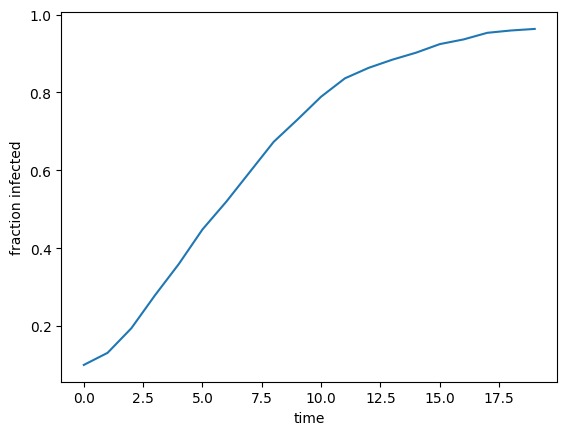

In [112]:
G = nx.barabasi_albert_graph(1000, 4)
plt.plot(run_SI(G, tmax=20, beta=0.05, initial_inf=0.1))
plt.xlabel("time")
plt.ylabel("fraction infected")
plt.show()

Let's try aggregating results from multiple runs. Let's do 50 runs and plot them all to see the variation.

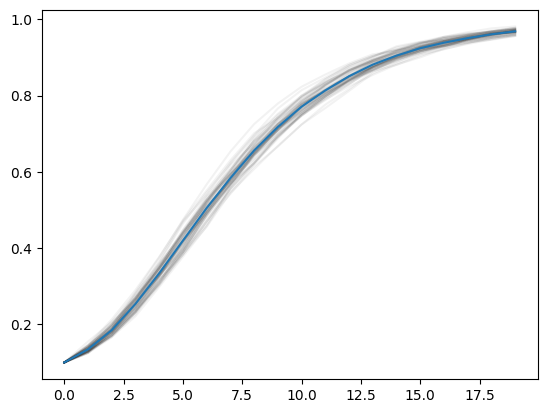

In [113]:
# Plot individual runs in light grey with small alpha (more transparent) and the average in blue

G = nx.barabasi_albert_graph(1000, 4)

# YOUR SOLUTION HERE

As you can see, it shows an S-shaped curve that is typical of the spread of infectious diseases. The number of infected nodes grows exponentially at first, then slows down to saturate as the number of susceptible nodes decreases. 

This type of average is commonly done, but a care must be taken when aggregating epidemic (forecast) curves. [A very nice paper by Jonas Juul et al.](https://www.nature.com/articles/s41567-020-01121-y) showed that this type of aggregation (fixed-time descriptive statistics) can underestimate extreme cases. 

<img src="https://yyiki.s3.us-east-2.amazonaws.com/public/imgs/juul_lehmann-pitfalls_in_using_fixed_time_desc_stat_in_epidemic_curve_ensembles.png" width=600>

As you can see, the median curve (the black solid line) heavily underestimate how high the peak is expected to be. Our simulation does not show this because everything is aligned to the same time step, but this was a very important insight in the early days of the COVID-19 pandemic, when it is difficult to forecast when the epidemic curve would take off. 

## SIR model 

SI model is useful to understand the early stage behavior of the epidemic. But the most commonly used model is the SIR model. In this model, the infected nodes can recover and become immune. For the sake of simplicity, you can assume that there is a recovery probability parameter that is the same for all nodes. In each time step, each infected node can recover and becomes immune with this probability.

**Q: implement the SIR model.**

1. Implement `run_SIR()`. 
2. Make a function that runs the SIR model and then produces a plot of "S", "I", "R" states (number of nodes) over time from the run. Show them in the same plot. 

In [115]:
def run_SIR(graph: nx.Graph, tmax: int, beta: float, mu: float, initial_inf: float):
    # YOUR SOLUTION HERE